In [1]:
from LogisticRegression import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Data location

In [2]:
data_path = "data/clean_data.csv"
save_directory = "current_accuracies/logistic_regression/logistic_regression_weights"
accuracies_file_path = "current_accuracies/logistic_regression/LogisticRegression_accuracies.pkl"

if not os.path.isdir(save_directory):
    os.mkdir(save_directory)

# Load data

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.shape

(11627, 39)

In [5]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [6]:
df.iloc[:, 1: 23].columns, df.iloc[:, 23: 31].columns

(Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
        'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
        'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
        'LDLC'],
       dtype='object'),
 Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
        'HYPERTEN'],
       dtype='object'))

In [7]:
print(df.iloc[:, 1: 23].shape[1], df.iloc[:, 23: 31].shape[1])

22 8


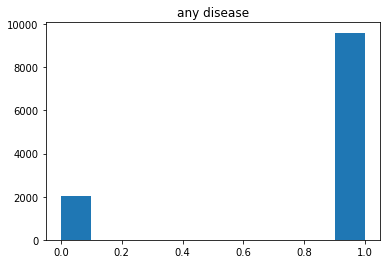

In [9]:
data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)
amax_label = np.amax(data[:, 23:31], axis=1)
hist,bins = np.histogram(amax_label) 

plt.hist(amax_label, bins = bins) 
plt.title("any disease") 
plt.show()

In [10]:
df

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448.0,1.0,195.0,39.0,106.0,70.0,0.0,0.0,26.970,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
1,2448.0,1.0,209.0,52.0,121.0,66.0,0.0,0.0,27.794,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
2,6238.0,0.0,250.0,46.0,121.0,81.0,0.0,0.0,28.730,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
3,6238.0,0.0,260.0,52.0,105.0,70.0,0.0,0.0,29.430,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
4,6238.0,0.0,237.0,58.0,108.0,66.0,0.0,0.0,28.500,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,9998212.0,1.0,173.0,46.0,126.0,82.0,0.0,0.0,19.170,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11623,9998212.0,1.0,153.0,52.0,143.0,89.0,0.0,0.0,25.740,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11624,9999312.0,0.0,196.0,39.0,133.0,86.0,1.0,30.0,20.910,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0
11625,9999312.0,0.0,240.0,46.0,138.0,79.0,1.0,20.0,26.390,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0


# Prepare the data

In [11]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

split_proportions = [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]

# Data verification

In [12]:
heart_dataset = HeartDiseaseDataset(data_path, any_disease=False)
train_dataloader_verif, val_dataloader_verif, test_dataloader_verif = create_dataloaders(heart_dataset, batch_size=1, split_proportions=split_proportions)

In [13]:
participant = next(iter(train_dataloader_verif))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[1.0000, 0.1919, 0.2653, 0.2607, 0.3667, 0.0000, 0.0000, 0.3047, 0.0000,
         0.0000, 0.1803, 0.1390, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2011, 0.3394]])
label ==>
 tensor([[0., 1.]])


==== Training DEATH ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2894 - acc: 0.7097 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 886us/step - loss: 0.0883 - acc: 0.7440 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.755
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2609 - acc: 0.7435 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 903us/step - loss: 1.0278 - acc: 0.7847 - lr: 0.0500
Model saved. Acc updated: 0.755 -> 0.762
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2533 - acc: 0.7602 - lr: 0.0500
Validation
2442/2442 [==============================] - 110s 45ms/step - loss: 0.0340 - acc: 0.7709 - lr: 0.0500
Model saved. Acc updated: 0.762 -> 0.768
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.2500 - acc: 0.7675 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 991us/st

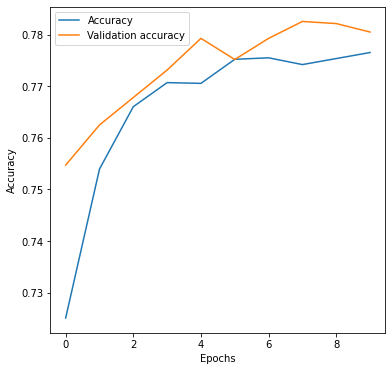




==== Training ANGINA ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2053 - acc: 0.8417 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0758 - acc: 0.8837 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.887
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1685 - acc: 0.8941 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0494 - acc: 0.8920 - lr: 0.0500
Model saved. Acc updated: 0.887 -> 0.890
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1719 - acc: 0.8857 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 955us/step - loss: 0.0450 - acc: 0.8873 - lr: 0.0500
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1687 - acc: 0.8869 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 954us/step - loss: 0.0394 - acc: 0.8874 - lr: 0.05

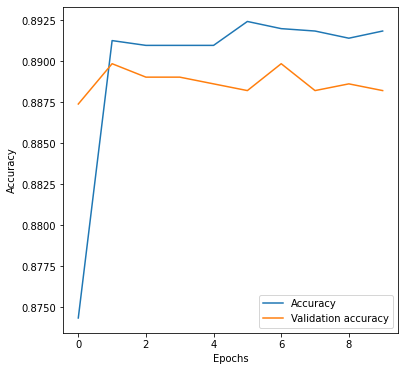




==== Training HOSPMI ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1702 - acc: 0.8868 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 993us/step - loss: 0.0546 - acc: 0.8999 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.903
Epoch 2 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1373 - acc: 0.9043 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0546 - acc: 0.9175 - lr: 0.0500
Model saved. Acc updated: 0.903 -> 0.914
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1354 - acc: 0.9128 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 948us/step - loss: 0.0291 - acc: 0.9166 - lr: 0.0500
Model saved. Acc updated: 0.914 -> 0.915
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1364 - acc: 0.9110 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/ste

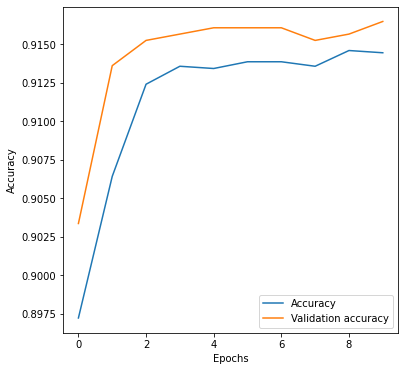




==== Training MI_FCHD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2142 - acc: 0.8410 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 950us/step - loss: 0.0854 - acc: 0.8757 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.870
Epoch 2 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1800 - acc: 0.8635 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 950us/step - loss: 0.0621 - acc: 0.8665 - lr: 0.0500
Epoch 3 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1880 - acc: 0.8540 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 949us/step - loss: 0.0293 - acc: 0.8714 - lr: 0.0500
Model saved. Acc updated: 0.870 -> 0.871
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1756 - acc: 0.8716 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 949us/step - loss: 0.0602 - acc: 0.8642 - lr:

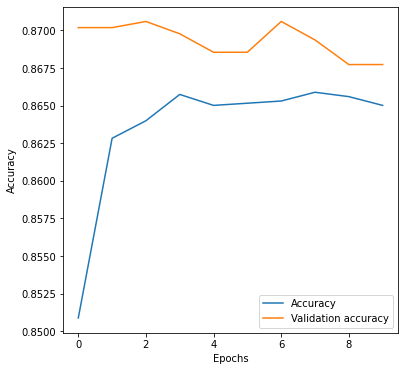




==== Training ANYCHD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2695 - acc: 0.7590 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 949us/step - loss: 0.6584 - acc: 0.8151 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.805
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2270 - acc: 0.8066 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 986us/step - loss: 0.9034 - acc: 0.8025 - lr: 0.0500
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2315 - acc: 0.7952 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 948us/step - loss: 0.1700 - acc: 0.8119 - lr: 0.0500
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.2275 - acc: 0.7960 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 946us/step - loss: 0.8561 - acc: 0.7985 - lr: 0.0500
Epoch 5 / 10
6860/6860 [==========

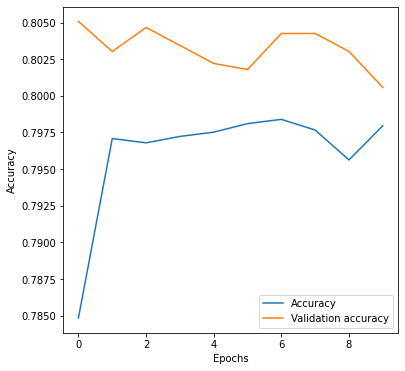




==== Training STROKE ====

Epoch 1 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1680 - acc: 0.9025 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 949us/step - loss: 0.0169 - acc: 0.9037 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.914
Epoch 2 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1346 - acc: 0.9091 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0269 - acc: 0.9113 - lr: 0.0500
Model saved. Acc updated: 0.914 -> 0.915
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1260 - acc: 0.9163 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 950us/step - loss: 0.0282 - acc: 0.9175 - lr: 0.0500
Model saved. Acc updated: 0.915 -> 0.919
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1299 - acc: 0.9169 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 962us/s

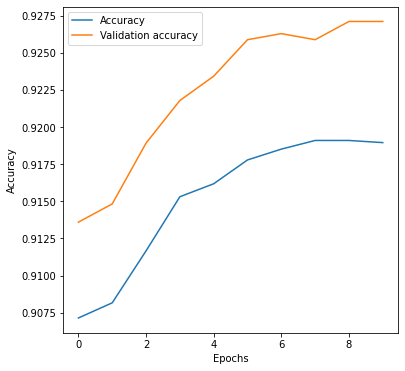




==== Training CVD ====

Epoch 1 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2639 - acc: 0.7610 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.2201 - acc: 0.7792 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.785
Epoch 2 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2386 - acc: 0.7834 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 944us/step - loss: 0.1723 - acc: 0.7818 - lr: 0.0500
Model saved. Acc updated: 0.785 -> 0.786
Epoch 3 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2355 - acc: 0.7892 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 943us/step - loss: 0.3604 - acc: 0.8044 - lr: 0.0500
Model saved. Acc updated: 0.786 -> 0.792
Epoch 4 / 10
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2304 - acc: 0.7957 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 936us/step

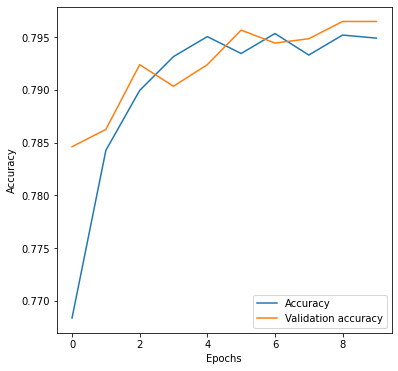




==== Training HYPERTEN ====

Epoch 1 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.2195 - acc: 0.7465 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 943us/step - loss: 0.0154 - acc: 0.7906 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.787
Epoch 2 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1796 - acc: 0.8023 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 941us/step - loss: 0.3195 - acc: 0.7976 - lr: 0.0500
Model saved. Acc updated: 0.787 -> 0.794
Epoch 3 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1762 - acc: 0.7968 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 944us/step - loss: 0.0049 - acc: 0.8015 - lr: 0.0500
Model saved. Acc updated: 0.794 -> 0.797
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1721 - acc: 0.8001 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 942

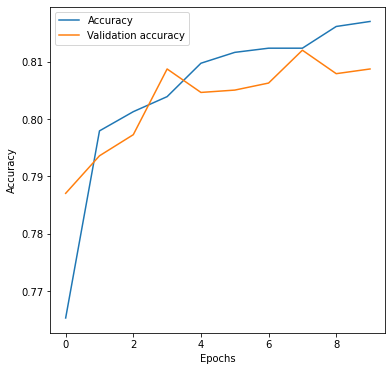

In [14]:
nb_epochs = 10
trainers = train_labels(df.iloc[:, 23: 31].columns, data_path, 
                        df.iloc[:, 23: 31].columns, split_proportions, 
                        save_directory, nb_epochs)

# Test

==== Evaluate DEATH ====

accuracy 78.58064516129032


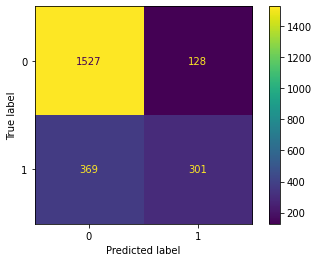

sensitivity : 0.44925373134328356, specificity : 0.9226586102719033, PPV : 0.7016317016317016, NPV : 0.805379746835443



==== Evaluate ANGINA ====

accuracy 88.04301075268818


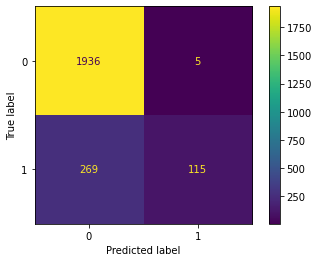

sensitivity : 0.2994791666666667, specificity : 0.9974240082431737, PPV : 0.9583333333333334, NPV : 0.8780045351473923



==== Evaluate HOSPMI ====

accuracy 92.04301075268818


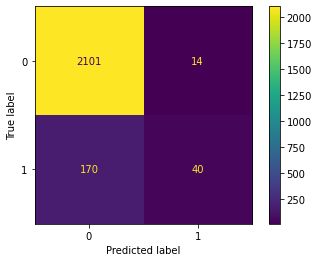

sensitivity : 0.19047619047619047, specificity : 0.9933806146572104, PPV : 0.7407407407407407, NPV : 0.9251431087626596



==== Evaluate MI_FCHD ====

accuracy 88.0


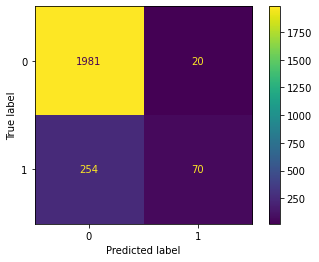

sensitivity : 0.21604938271604937, specificity : 0.9900049975012494, PPV : 0.7777777777777778, NPV : 0.8863534675615212



==== Evaluate ANYCHD ====

accuracy 80.38709677419355


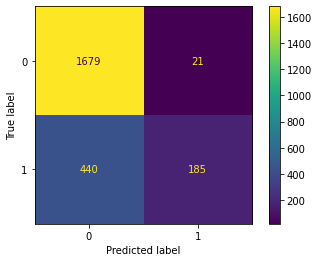

sensitivity : 0.296, specificity : 0.9876470588235294, PPV : 0.8980582524271845, NPV : 0.7923548843794243



==== Evaluate STROKE ====

accuracy 92.12903225806451


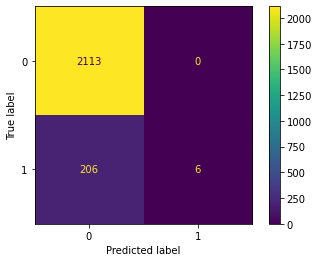

sensitivity : 0.02830188679245283, specificity : 1.0, PPV : 1.0, NPV : 0.9111686071582579



==== Evaluate CVD ====

accuracy 80.86021505376344


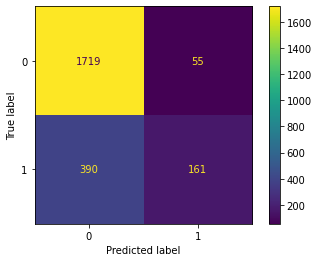

sensitivity : 0.29219600725952816, specificity : 0.9689966178128523, PPV : 0.7453703703703703, NPV : 0.8150782361308677



==== Evaluate HYPERTEN ====

accuracy 83.18279569892474


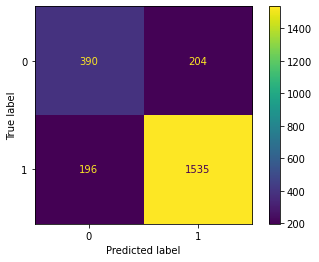

sensitivity : 0.8867706528018486, specificity : 0.6565656565656566, PPV : 0.882691201840138, NPV : 0.6655290102389079





In [16]:
accuracies = prediction_analyse_labels(df.iloc[:, 23: 31].columns, trainers, df.iloc[:, 23: 31].columns, data_path, split_proportions)

In [21]:
save_accuracies_pkl(accuracies_file_path, accuracies)